## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import resample
import itertools
import tensorflow as tf

import keras
from keras.applications import ResNet50
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
np.random.seed(123)

## CNN Model

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
 #for x in glob(os.path.join('/content/drive/MyDrive/SkinLesion_Two_Classes/', '*', '*.jpg'))}
for x in glob(os.path.join('/content/drive/MyDrive/SkinLesion_7_Classes/', '*', '*.jpg'))}

In [ ]:
#Load HAM10000 data
#skin_df=pd.read_csv('/content/drive/MyDrive/HAM10000_metadataBinary.csv')
skin_df=pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')

In [ ]:
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [ ]:
##Data Balancimg
df_0 = skin_df[skin_df['cell_type_idx'] == 0]
df_1 = skin_df[skin_df['cell_type_idx'] == 1]
df_2 = skin_df[skin_df['cell_type_idx'] == 2]
df_3 = skin_df[skin_df['cell_type_idx'] == 3]
df_4 = skin_df[skin_df['cell_type_idx'] == 4]
df_5 = skin_df[skin_df['cell_type_idx'] == 5]
df_6 = skin_df[skin_df['cell_type_idx'] == 6]

# number of samples
n_samples=2000 

df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined to a single dataframe
skin_df = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the data distribution
print(skin_df['cell_type_idx'].value_counts())

In [6]:
# resize the image into 112x112
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((112,112))))

In [7]:
# Assigned the feastres and the target
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [8]:
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

#The normalisation is done using the training set Mean and Std. Deviation as reference
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(112, 112, 3))
x_test = x_test.reshape(x_test.shape[0], *(112, 112, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(112, 112, 3))

In [9]:
# Define some parametersfor the Model
size=(112,112)
num_classes = 7
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 100
batch_size = 32
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

In [10]:
model_checkpoint_callback = ModelCheckpoint(filepath='/content/drive/MyDrive/model_regnet_7class_imbalanced.h5',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='auto',
                                            save_best_only=True,
                                            verbose=1)

In [11]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        ) 

#### Load CNN Model

In [12]:
base_model = tf.keras.applications.RegNetX032(include_top=False, input_shape=(112,112, 3),pooling = 'avg', weights = 'imagenet')

58216992/58216992 [==============================] - 4s 0us/step


In [13]:
RegNetX032model = Sequential()
RegNetX032model.add(base_model)
RegNetX032model.add(Dense(num_classes, activation = 'softmax'))

In [ ]:

RegNetX032model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = RegNetX032model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 0, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor,model_checkpoint_callback])

#### Ploting the Learning Curve

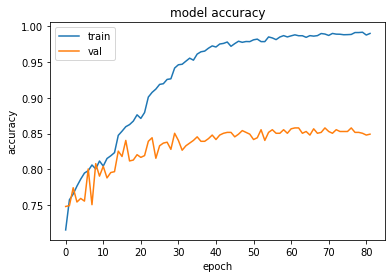

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

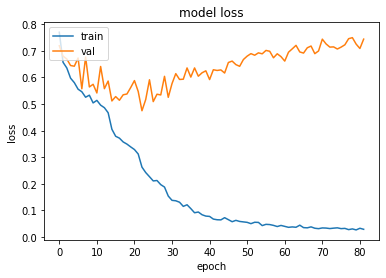

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Building a report 

In [17]:
predictions = (RegNetX032model.predict(x_test) > 0.5).astype("int32")

63/63 [==============================] - 5s 64ms/step


In [18]:
predictions_train = (RegNetX032model.predict(x_train) > 0.5).astype("int32")

226/226 [==============================] - 9s 38ms/step


In [19]:
predictions_validate = (RegNetX032model.predict(x_validate) > 0.5).astype("int32")

26/26 [==============================] - 1s 34ms/step


In [31]:
print(classification_report(y_test, predictions, target_names=['akiec','bcc','bkl','df','nv','mel','vasc'],digits=4  ))


              precision    recall  f1-score   support

       akiec     0.7018    0.6250    0.6612        64
         bcc     0.7455    0.8200    0.7810       100
         bkl     0.7500    0.6933    0.7206       225
          df     0.8333    0.6250    0.7143        24
          nv     0.9201    0.9417    0.9307      1320
         mel     0.6773    0.6208    0.6478       240
        vasc     0.9200    0.7667    0.8364        30

   micro avg     0.8587    0.8527    0.8557      2003
   macro avg     0.7926    0.7275    0.7560      2003
weighted avg     0.8551    0.8527    0.8531      2003
 samples avg     0.8527    0.8527    0.8527      2003



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
print(classification_report(y_train, predictions_train, target_names=['akiec','bcc','bkl','df','nv','mel','vasc'], digits=4 ))

              precision    recall  f1-score   support

       akiec     0.9832    0.9915    0.9873       236
         bcc     0.9946    0.9946    0.9946       370
         bkl     0.9761    0.9873    0.9816       785
          df     1.0000    1.0000    1.0000        82
          nv     0.9961    0.9920    0.9940      4854
         mel     0.9670    0.9719    0.9694       783
        vasc     1.0000    1.0000    1.0000       100

   micro avg     0.9903    0.9896    0.9899      7210
   macro avg     0.9881    0.9910    0.9896      7210
weighted avg     0.9903    0.9896    0.9900      7210
 samples avg     0.9896    0.9896    0.9896      7210



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
print(classification_report(y_validate, predictions_validate, target_names=['akiec','bcc','bkl','df','nv','mel','vasc'],digits=4 ))

              precision    recall  f1-score   support

       akiec     0.6538    0.6296    0.6415        27
         bcc     0.8140    0.7955    0.8046        44
         bkl     0.6774    0.7079    0.6923        89
          df     0.8000    0.4444    0.5714         9
          nv     0.9306    0.9341    0.9323       531
         mel     0.6444    0.6444    0.6444        90
        vasc     1.0000    0.6667    0.8000        12

   micro avg     0.8534    0.8491    0.8512       802
   macro avg     0.7886    0.6889    0.7267       802
weighted avg     0.8542    0.8491    0.8506       802
 samples avg     0.8491    0.8491    0.8491       802



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

In [34]:
# Confusion Matrix -Test
print(confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1)))

[[  41    6    6    2    3    6    0]
 [   6   82    5    0    3    4    0]
 [  14    9  156    1   30   15    0]
 [   1    2    2   15    4    0    0]
 [   5    6   21    0 1243   45    0]
 [   4    2   18    0   65  149    2]
 [   0    3    0    0    3    1   23]]


In [35]:
# Confusion Matrix -Train
print(confusion_matrix(y_train.argmax(axis=1), predictions_train.argmax(axis=1)))

[[ 234    0    1    0    0    1    0]
 [   0  368    2    0    0    0    0]
 [   4    1  775    0    3    2    0]
 [   0    0    0   82    0    0    0]
 [   2    0   14    0 4815   23    0]
 [   3    1    2    0   16  761    0]
 [   0    0    0    0    0    0  100]]


In [36]:
# Confusion Matrix -validate
print(confusion_matrix(y_validate.argmax(axis=1), predictions_validate.argmax(axis=1)))

[[ 17   1   6   0   0   3   0]
 [  3  35   3   0   2   1   0]
 [  3   2  63   1   9  11   0]
 [  3   0   1   4   1   0   0]
 [  4   4  10   0 496  17   0]
 [  0   1   9   0  22  58   0]
 [  0   0   1   0   3   0   8]]


In [26]:
#best_model = load_model('/content/drive/MyDrive/model_regnet.h5')